# Tutorial 1: A quickstart for Mitsuba building blocks

In [2]:
from typing import *
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
%matplotlib widget

import drjit as dr
import mitsuba as mi
# mi.set_variant('cuda_ad_rgb')
mi.set_variant('scalar_rgb')

-----
## 1. Random number generator: `mi.Sampler` class
A `mi.Sampler` instance can be easily understood as a random number generator.
`sampler.next_1d()` is similar to `np.random.rand()`, and `sampler.next_2d()` is similar to `np.random.rand(2)`, when `sampler` is an instance of `mi.Sampler` class.

In [22]:
sampler = mi.load_dict({'type': 'independent'})
print(f"{type(sampler) = }")
assert isinstance(sampler, mi.Sampler)
print(sampler) # This shows some attributes for `sampler`, but we have not to care about any of them now.

print(f"{type(sampler.next_1d()) = }")

sampler.seed(1)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")

sampler.seed(1)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")

next_2d = sampler.next_2d()
print(f"\n{type(next_2d) = }")
assert isinstance(next_2d, mi.Point2f)
print(f"{next_2d = }")

type(sampler) = <class 'mitsuba.scalar_rgb.Sampler'>
IndependentSampler[
  base_seed = 0
  sample_count = 4
  samples_per_wavefront = 1
  wavefront_size = 0
]
type(sampler.next_1d()) = <class 'float'>

The seed has been set to be 1.
sampler.next_1d() = 0.9390237331390381
sampler.next_1d() = 0.6919573545455933
sampler.next_1d() = 0.9697715044021606

The seed has been set to be 1.
sampler.next_1d() = 0.9390237331390381
sampler.next_1d() = 0.6919573545455933
sampler.next_1d() = 0.9697715044021606

type(next_2d) = <class 'mitsuba.scalar_rgb.Point2f'>
next_2d = [0.6498324871063232, 0.30470728874206543]


**Task 1.** Check independence of subsequent outputs of `sampler.next_1d` through numerical experiment

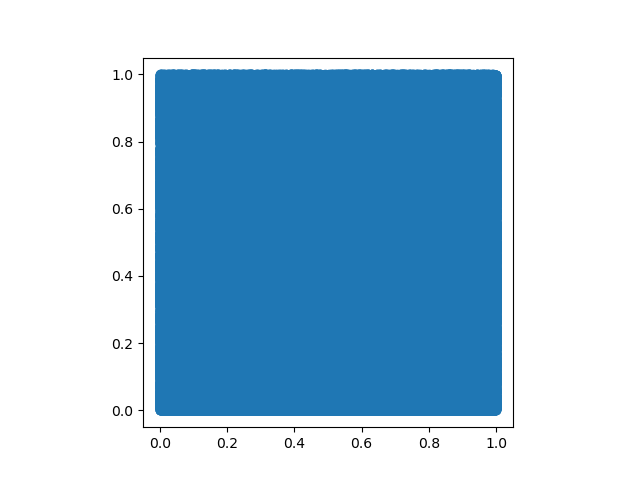

In [8]:
N = 1000000
First = np.zeros(N)
Second = np.zeros(N)

for seed in range(N):
    sampler.seed(seed)
    First[seed] = sampler.next_1d()
    Second[seed] = sampler.next_1d()

# --- Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(First, Second)
ax.set_aspect('equal')
plt.show()

Consecutivly calling `next_1d` or `next_2d` gives *independent* random samples. Check they are really independent. Showing independence of random variables are too difficult, so we will check a weak version (necessary condition): if $X$ and $Y$ are two independent random variables, then $X^n Y^m$ should have zero covariance.

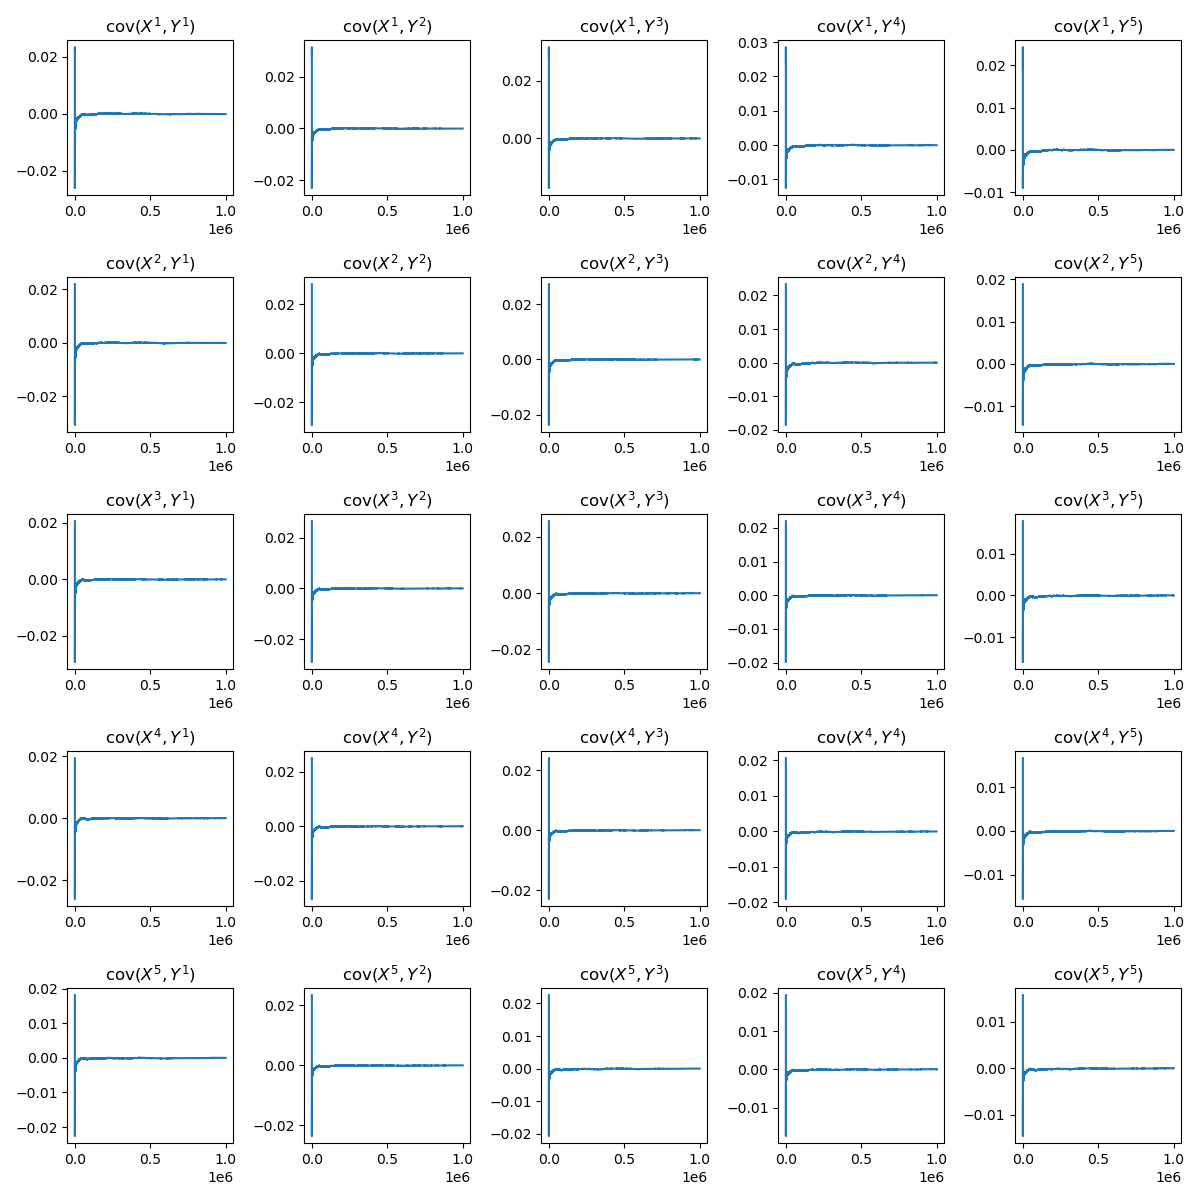

In [9]:
def cummean(a, axis=None):
    a_cumsum = np.cumsum(a, axis=axis)
    if axis is None:
        count = np.arange(1, a.size+1).reshape(a.shape)
    else:
        if axis < 0:
            axis = a.ndim + axis
        count = np.expand_dims(np.arange(1, a.shape[axis]+1), tuple(range(axis-a.ndim+1, 0)))
    return a_cumsum / count

max_power = 5
# Array[power of First, power of Second, sample for each seed]
first_power = np.arange(1, max_power+1)[:, None, None]
second_power = np.arange(1, max_power+1)[None, :, None]

First_powered = First**first_power
Second_powered = Second**second_power
Cov = cummean(First_powered*Second_powered, axis=-1) - cummean(First_powered, axis=-1) * cummean(Second_powered, axis=-1)
Cov = Cov[:,:,1:]

# --- Plot
plot_X = np.arange(1, N)
fig = plt.figure(figsize=(12,12))
for i in range(max_power):
    for j in range(max_power):
        ax = fig.add_subplot(max_power, max_power, i*max_power + j+1)
        ax.plot(plot_X, Cov[i, j, :])
        ax.set_title("$\\mathrm{cov}\\left(X^{%d}, Y^{%d}\\right)$" % (i+1, j+1))
plt.tight_layout()
plt.show()

-----
## 2. Ray intersection: `mi.Ray3f` class and `mi.Scene.ray_intersect` method
First, generate a example scene using `mi.cornell_box()`. A Mitsuba function `mi.load_dict` will convert a Python dictionary to a certain type of Mitsuba object.

In [23]:
scene = mi.load_dict(mi.cornell_box())
print(f"{type(scene) = }")
print(scene)

type(scene) = <class 'mitsuba.scalar_rgb.Scene'>
Scene[
  children = [
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, -1],
                  [0, 0, 0, 1]],
      frame = Frame[
        s = [2, 0, 0],
        t = [0, 2, 0],
        n = [0, 0, 1]
      ],
      surface_area = 4,
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.885809, 0.698859, 0.666422]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, -4.37114e-08, -1, 1],
                  [0, 1, -4.37114e-08, 0],
                  [0, 0, 0, 1]],
      frame = Frame[
        s = [2, 0, 0],
        t = [0, -8.74228e-08, 2],
        n = [0, -1, -4.37114e-08]
      ],
      surface_area = 4,
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [0.885809, 0.698859, 0.666422]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
     

`mi.Ray3f` is a class for *rays*, which consist of origin points and direction vectors.

`mi.Scene.ray_intersect` method performs the ray intersection query. Note that it returns not only intersection point location, but a structure named `mi.SurfaceInteraction3f` which consists of several information of the ray intersection query.

In [54]:
print("# mi.Ray3f object")
ray = mi.Ray3f(0, (1,1,0)/np.sqrt(2))
print(f"{type(ray) = }")
print(ray)
print(ray.o)
print(ray.d)

print("\n# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object")
si = scene.ray_intersect(ray)
print(f"{type(si) = }")
assert isinstance(si, mi.SurfaceInteraction3f)
print(si)

# mi.Ray3f object
type(ray) = <class 'mitsuba.scalar_rgb.Ray3f'>
Ray3f[
  o = [0, 0, 0],
  d = [0.707107, 0.707107, 0],
  maxt = 3.40282e+38,
  time = 0,
]
[0.0, 0.0, 0.0]
[0.7071067690849304, 0.7071067690849304, 0.0]

# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object
type(si) = <class 'mitsuba.scalar_rgb.SurfaceInteraction3f'>
SurfaceInteraction[
  t = 1.41421,
  time = 0,
  wavelengths = [],
  p = [1, 1, 2.6054e-15],
  shape = Rectangle[
    to_world = [[-4.37114e-08, 0, -1, 1],
                [0, 1, 0, 0],
                [1, 0, -4.37114e-08, 0],
                [0, 0, 0, 1]],
    frame = Frame[
      s = [-8.74228e-08, 0, 2],
      t = [0, 2, 0],
      n = [-1, 0, -4.37114e-08]
    ],
    surface_area = 4,
    bsdf = SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [0.105421, 0.37798, 0.076425]
      ]
    ]
  ],
  uv = [0.5, 1],
  n = [-1, 0, -4.37114e-08],
  sh_frame = Frame[
    s = [-4.37114e-08, 0, 1],
    t = [0, 1, 0],
    n = [-1

### Visualize ray intersection
The following block visualizes a ray instance and the result of ray intersection. See also the printed text carefully. Please do not confuse that `si.wi` is written respect to the local frame of the intersection point.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


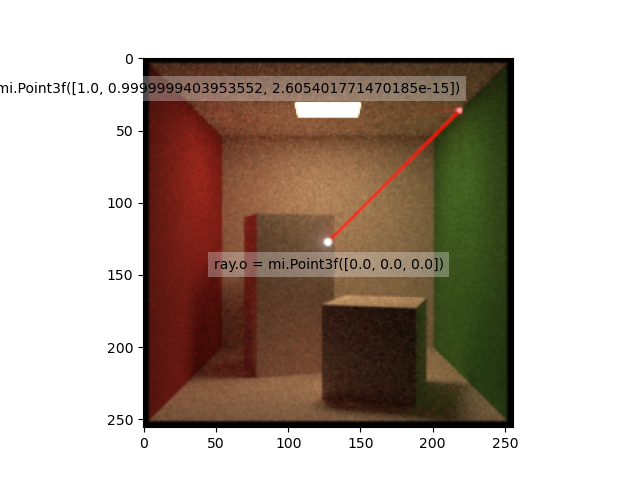

si.p == ray.o + si.t * ray.d
-ray.d == si.sh_frame.to_world(si.wi)


In [28]:
# "Mi"tsuba objects in "dict"ionary
def midict_area(rgb: ArrayLike # [3]
               ) ->  dict:
    return {'type': 'area',
            'radiance': {'type': 'rgb',
                         'value': rgb}}

def midict_diffuse(reflectance: ArrayLike) -> dict:
    return {'type': 'diffuse',
            'reflectance': {'type': 'rgb',
                            'value': reflectance}}

def midict_sphere(center:  ArrayLike,
                  radius:  float,
                  bsdf:    Union[dict, str],
                  emitter: Union[dict, str, None] = None
                 ) ->      dict:
    res = {'type': 'sphere',
           'center': center,
           'radius': radius}
    if type(bsdf) == str:
        res['bsdf'] = {'type': 'ref', 'id': bsdf}
    elif type(bsdf) == dict:
        res['bsdf'] = bsdf
    else:
        raise TypeError(f"Unsupported type ({type(bsdf)}) for `bsdf`.")
    if type(emitter) == str:
        res['emitter'] = {'type': 'ref', 'id': emitter}
    elif type(emitter) == dict:
        res['emitter'] = emitter
    elif emitter is not None:
        raise TypeError(f"Unsupported type ({type(emitter)}) for `emitter`.")
    return res

def world2img(point: mi.Point3f, scene: mi.Scene) -> mi.Point2u:
    """
    Assume height and width are equal. TODO: generalize
    """
    params = mi.traverse(scene)
    fov = params['sensor.x_fov']
    sensor_tf = params['sensor.to_world']
    # size = params['sensor.film.size'][0]
    size = scene.sensors()[0].film().size()[0]
    
    point_in_sensor = sensor_tf @ point
    point_imgplane = -mi.Point2f(point_in_sensor.x/point_in_sensor.z, point_in_sensor.y/point_in_sensor.z)
    return mi.Point2u((point_imgplane / dr.tan(dr.deg2rad(fov/2)) + 1) * size / 2)

def text_at(point: mi.Point3f, scene: mi.Scene, text: str, ha: str="center", va: str="top"):
    pixpos = world2img(point, scene)
    xoffset = 0
    yoffset = 10 if va == "top" else -10
    kargs = dict(size=10, ha=ha, va=va, bbox=dict(ec = (0.,0.,0.,0.),
                                                  fc=(1.,1.,1., 0.3)))
    plt.text(pixpos[0] + xoffset, pixpos[1] + yoffset,
             text, **kargs)
        
def show_ray(ray: mi.Ray3f, si: mi.SurfaceInteraction3f):
    scene_dict = mi.cornell_box()
    scene_dict['zero_bsdf'] = midict_diffuse([0, 0, 0])
    
    scene_dict['ray'] = {
        'type': 'cylinder',
        'p0': ray.o,
        'p1': si.p,
        'radius': 0.01,
        'bsdf': {'type': 'ref', 'id': 'zero_bsdf'},
        'emitter': midict_area([1, 0, 0])}
    scene_dict['origin'] = midict_sphere(ray.o, 0.03, 'zero_bsdf', midict_area([1, 1, 1]))
    scene_dict['intersection'] = midict_sphere(si.p, 0.03, 'zero_bsdf', midict_area([2, 0.4, 0.4]))

    scene_visualize = mi.load_dict(scene_dict)
    img = mi.render(scene_visualize, spp=100)
    plt.imshow(img**(1/2.2))
    
    text_at(ray.o, scene_visualize, f"ray.o = mi.Point3f({ray.o})")
    text_at(si.p, scene_visualize, f"si.p = mi.Point3f({si.p})", ha="right", va="bottom")

plt.figure()  
show_ray(ray, si)
plt.show()

assert dr.allclose(si.p, ray.o + si.t * ray.d)
print("si.p == ray.o + si.t * ray.d")

assert not dr.allclose(ray.d, si.wi)
assert not dr.allclose(-ray.d, si.wi)
assert not dr.allclose(ray.d, si.sh_frame.to_world(si.wi))
assert dr.allclose(-ray.d, si.sh_frame.to_world(si.wi))
print("-ray.d == si.sh_frame.to_world(si.wi)")

## 3. BSDFs and their sampling: `mi.BSDF`
### `mi.BSDF` class

We can extract a BSDF object at the intersecting point as a property of the `mi.SurfaceInteraction3f` instance.

In [35]:
bsdf = si.bsdf()
print(f"{type(bsdf) = }")
assert isinstance(bsdf, mi.BSDF)
print(bsdf)

type(bsdf) = <class 'mitsuba.scalar_rgb.BSDF'>
SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [0.105421, 0.37798, 0.076425]
  ]
]


Important method usages:

* `bsdf.sample(ctx, si, u_1d, u_2d)` produces a random variable whose PDF is as proportional to $f_s\left(\hat\omega_i,\cdot\right)\left|\hat n \cdot \hat\omega_i\right|$ as possible. (or $f_s\left(\cdot,\hat\omega_o,\right)\left|\hat n \cdot \hat\omega_o\right|$)
* `bsdf.eval(ctx, si, wo)`$= f_s($`si.wi`$, $`wo`$)\left|\hat n \cdot \hat \omega_i\right|$
* `bsdf.pdf(ctx, si, wo)` evaluates the PDF for the sampling strategy of `bsdf.sample()`

Here, `bsdf.sample` returns not only sampled direction or BSDF value, but a 2-tuple of a `mi.BSDFSample3f` structure, which contains several information through BSDF sampling process, and a *weight* for MC integration, which is equal to:
$$
\mathtt{bsdf\_weight}=\frac{f_s\left(\hat\omega_i,\hat\omega_o\right)\left|\hat n \cdot \hat \omega_i\right|}{p\left(\hat\omega_o\mid\hat\omega_i\right)}.
$$

See the following results of the code block. Note that we do not investigate `ctx = mi.BSDFContext()` instance deeply now.

In [42]:
print("# ---------- Methods usage ----------")
ctx = mi.BSDFContext()
u_1d = sampler.next_1d()
u_2d = sampler.next_2d()
bsdf_sample, bsdf_weight = bsdf.sample(ctx, si, u_1d, u_2d)

print(f"{type(bsdf_sample) = }")
assert isinstance(bsdf_sample, mi.BSDFSample3f)
print(bsdf_sample, '\n')

print(f"{type(bsdf_weight) = }")
print(bsdf_weight, '\n')

bsdf_eval, bsdf_pdf = bsdf.eval_pdf(ctx, si, bsdf_sample.wo)
print(f"{type(bsdf_eval) = }")
print(bsdf_eval, '\n')

print(f"{type(bsdf_pdf) = }")
print(bsdf_pdf, '\n')

print("# ---------- Assertions ----------")
print(f"{dr.allclose(bsdf_sample.pdf, bsdf_pdf) = }")
print(f"{dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = }")

# ---------- Methods usage ----------
type(bsdf_sample) = <class 'mitsuba.scalar_rgb.BSDFSample3f'>
BSDFSample[
  wo = [-0.936671, -0.217515, 0.27447],
  pdf = 0.0873666,
  eta = 1,
  sampled_type = TODO,
  sampled_component = 0
] 

type(bsdf_weight) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.10542099922895432, 0.37797999382019043, 0.07642500102519989] 

type(bsdf_eval) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.009210274554789066, 0.03302282840013504, 0.006676993332803249] 

type(bsdf_pdf) = <class 'float'>
0.08736660331487656 

# ---------- Assertions ----------
dr.allclose(bsdf_sample.pdf, bsdf_pdf) = True
dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = True


Note that `bsdf.eval_pdf()` is just a combination of `bsdf.eval()` and `bsdf.pdf()`.

In [44]:
print(f"{dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = }")
print(f"{dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = }")

dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = True
dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = True


### Spawn ray
Once sampled refelcted (or refracted) directions for given `bsdf` at `si`, we should usually construct a new ray object with origin `si.p` and direction `bsdf_sample.wo`. In this case, using the method `mi.SurfaceInteraction3f.spawn_ray()` is more recommended than directly calling the constructor `mi.Ray3f`.

In [52]:
ray_spawn = si.spawn_ray(si.to_world(bsdf_sample.wo))
print(ray_spawn)
print(si.p)

Ray3f[
  o = [0.999821, 1, -7.8136e-12],
  d = [-0.27447, -0.217515, -0.936671],
  maxt = 3.40282e+38,
  time = 0,
]
[1.0, 0.9999999403953552, 2.605401771470185e-15]


Here, we observe that `ray_spawn.o` has a tiny offset from `si.p`. It comes from an issue of numerical computation of floating-point numbers. Refer to the following material for details.

Pharr, Matt, Wenzel Jakob, and Greg Humphreys. Physically based rendering: From theory to implementation. MIT Press, 2023.
3 Shapes - 3.9 Managing Rounding Error
https://www.pbr-book.org/3ed-2018/Shapes/Managing_Rounding_Error

### Visualize BSDF sapmling
Try the following visualization of BSDF sampling. The single red dot indicates `wi` and many blue dots indicate sampled `wo`'s. The middle plot visualizes projection of sampled direction on $xy$ plane. In the following diffuse BRDF example, the BSDF is $f_s=\frac{\rho}{\pi}$. Observe that the sampled points are uniformly distributed not in the left plot, but in the middle plot. It indicates the sampling PDF is proportional to $f_s\cdot \cos\theta$, not just $f_s$.

In the right plot, we observe that the *weight* ($f_s\cdot \cos \theta/p$) value returned by `bsdf.sample()` records constant values.

In [45]:
def bsdf_sample_statistics(N: int, si: mi.SurfaceInteraction3f, sampler: mi.Sampler
                          ) -> Tuple[np.ndarray, np.ndarray]:
    wo = np.zeros((N, 3))
    weights = np.zeros((N, 3))
    for i in range(N):
        bsdf_sample, bsdf_weight = si.bsdf().sample(ctx, si, sampler.next_1d(), sampler.next_2d())
        wo[i, :] = bsdf_sample.wo.numpy()
        weights[i, :] = bsdf_weight.numpy()
    return wo, weights

N = 10000
wo, weights = bsdf_sample_statistics(N, si, sampler)

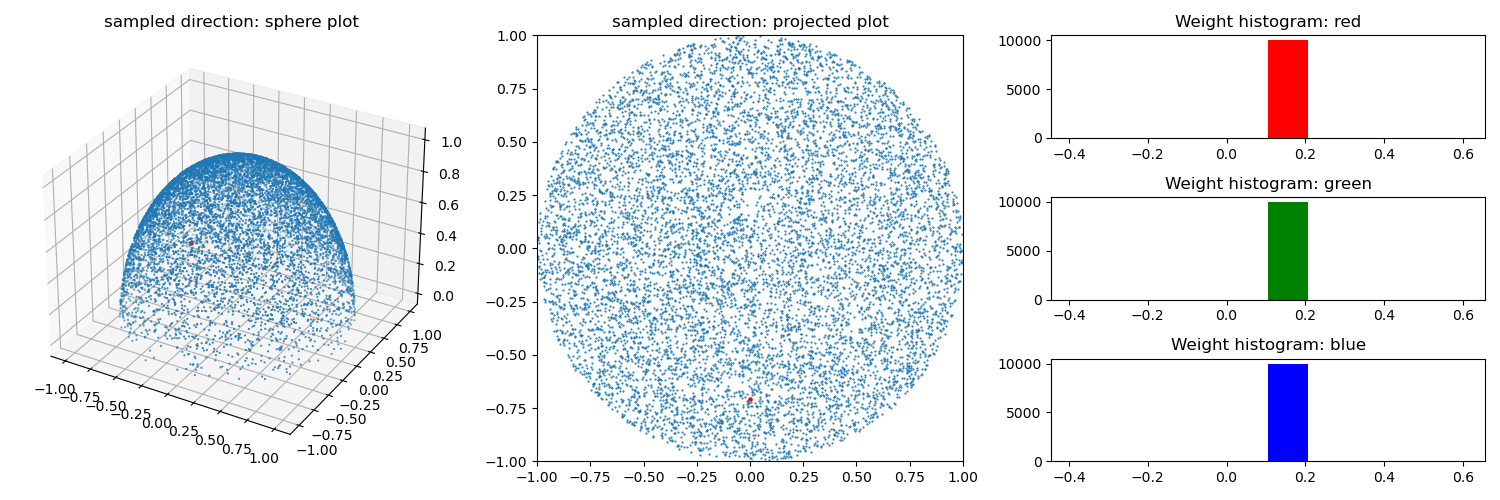

In [ ]:
def plot_bsdf_samples(wos: ArrayLike, # [N, 3],
                      weights: ArrayLike, #[N, 3]
                      wi: mi.Vector3f # [3]
                     ):
    # wos = wos / np.linalg.norm(wos, axis=1, keepdims=True)
    wi = np.array(wi)
    # wi = np.array(wi) / np.linalg.norm(wi)

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter(*(wos.T), s=0.3)
    ax.scatter(*(wi*1.05), s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: sphere plot")

    ax = fig.add_subplot(1, 3, 2, aspect='equal')
    ax.scatter(*(wos.T[:2,:]), s=0.3);
    ax.scatter(*wi[:2], s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: projected plot")

    for i,col in zip(range(3), ['red', 'green', 'blue']):
        ax = fig.add_subplot(3, 3, 3*i+3)
        ax.hist(weights[:,0], color=col)
        ax.set_title("Weight histogram: "+col)

    fig.tight_layout()
plot_bsdf_samples(wo, weights, si.wi)

In [ ]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughconductor',
                       'material': 'Al',
                       'distribution': 'ggx',
                       'alpha': 0.05}
scene2 = mi.load_dict(scene_dict)

si2 = scene2.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si2, sampler)
plot_bsdf_samples(wo, weights, si2.wi)

However, for a `roughplastic` material, we observe that the *weight* is not constant. Note that making a sampling strategy be proportional to $f_s \cdot\cos\theta$ is desirable if possible, but not strictly mandatory. If the BSDF function is too complicate, a similar PDF is okay.

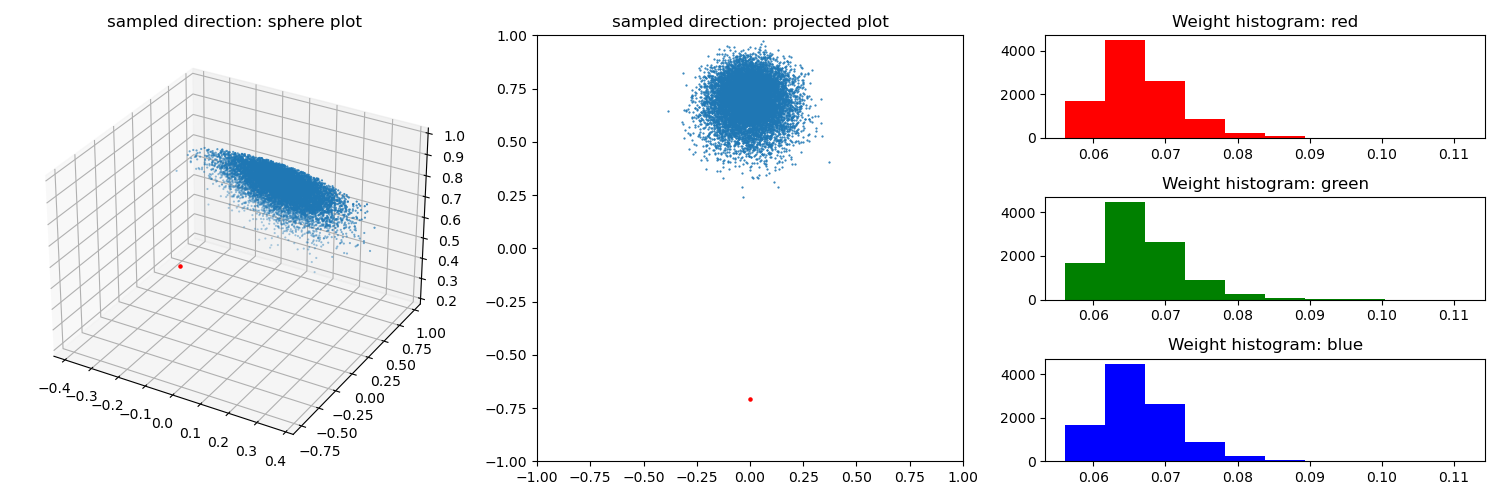

In [ ]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughplastic',
                       'distribution': 'beckmann',
                       'int_ior': 1.61,
                       'diffuse_reflectance': {
                            'type': 'rgb',
                            'value': 0
                       }}
scene3 = mi.load_dict(scene_dict)

si3 = scene3.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si3, sampler)
plot_bsdf_samples(wo, weights, si3.wi)

-----
## 4. Emitter sampling

In [16]:
scene = mi.load_dict(mi.cornell_box())
ray = mi.Ray3f(0, [dr.sqrt(3)/2, 0.5, 0])
si = scene.ray_intersect(ray)
u = sampler.next_2d()

ds, weight = scene.sample_emitter_direction(si, u)
print(f"{type(ds) = }")
print(ds, "\n")
print(f"{type(weight) = }")
print(weight, "\n")

print(f"{dr.allclose(dr.norm(ds.p - si.p), ds.dist) = }")
assert not dr.allclose(si.p- ds.p, ds.dist*ds.d)
print(f"{dr.allclose(ds.p -si.p, ds.dist*ds.d) = }")
print(f"{dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = }")

type(ds) = <class 'mitsuba.scalar_rgb.DirectionSample3f'>
DirectionSample3f[
  p = [-0.123591, 0.99, 0.159702],
  n = [0, -1, -4.37114e-08],
  uv = [0.231325, 0.893952],
  time = 0,
  pdf = 24.413,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBEmitterSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [-0.930451, 0.341717, 0.13225],
  dist = 1.20758
] 

type(weight) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.7531650066375732, 0.5729452967643738, 0.27663853764533997] 

dr.allclose(dr.norm(ds.p - si.p), ds.dist) = True
dr.allclose(ds.p -si.p, ds.dist*ds.d) = True
dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


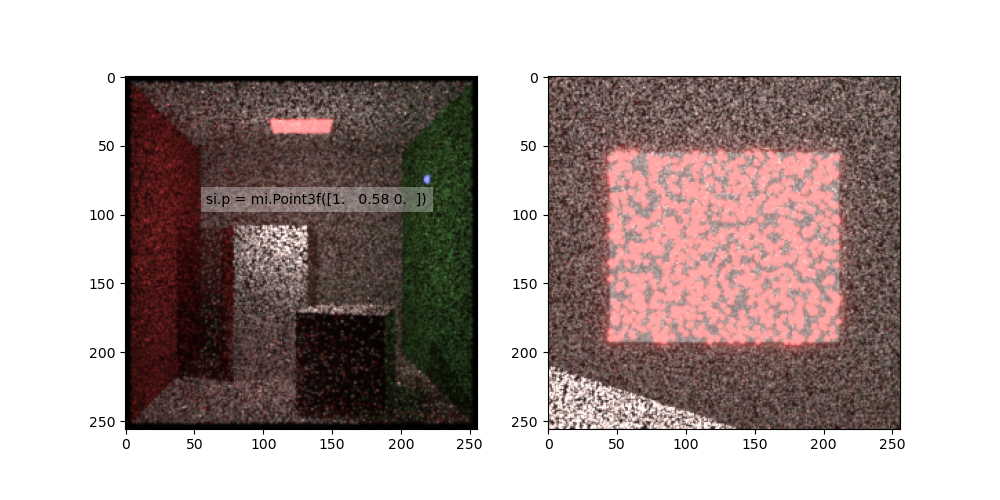

In [17]:
def show_ds(si: mi.SurfaceInteraction3f, ds_list: Sequence[mi.DirectionSample3f]):
    scene_dict = mi.cornell_box()
    scene_dict['integrator']['max_depth'] = 5
    scene_dict['zero_bsdf'] = midict_diffuse([0, 0, 0])

    # For visibility of `ds` on the light source
    scene_dict['light']['emitter']['radiance']['value'] = [0.2, 0.2, 0.2]
    scene_dict['point'] = {'type': 'point',
                           'position': [0, 0.2, 0.3],
                           'intensity': {'type': 'rgb', 'value': [0.3,0.3,0.3]}} 
    
    scene_dict['si'] = midict_sphere(si.p, 0.03, 'zero_bsdf', midict_area([0.4, 0.4, 2]))
    for i, ds in enumerate(ds_list):
        scene_dict[f'ds{i}'] = midict_sphere(ds.p, 0.005, 'zero_bsdf', midict_area([2, 0.4, 0.4]))
    scene_visualize = mi.load_dict(scene_dict)
    spp = 512
    img = mi.render(scene_visualize, spp=spp)
    plt.subplot(1, 2, 1)
    plt.imshow(img**(1/2.2))

    text_at(si.p, scene_visualize, f"si.p = mi.Point3f({si.p.numpy().round(2)})", ha='right', va='top')
    # ds0p = ds_list[0].p
    # text_at(ds0p, scene_visualize, f"ds_list[0].p = mi.Point3f({ds0p})", ha="center", va="top")

    scene_dict['sensor']['to_world'] = mi.ScalarTransform4f.look_at([0, 0, 0], [0, 1, 0], [0, 0, 1])
    scene_visualize = mi.load_dict(scene_dict)
    img = mi.render(scene_visualize, spp=spp)
    plt.subplot(1, 2, 2)
    plt.imshow(img**(1/2.2))
    

N = 1000
ds_list = []
for i in range(N):
    ds_temp, _ = scene.sample_emitter_direction(si, sampler.next_2d())
    ds_list.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si, ds_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


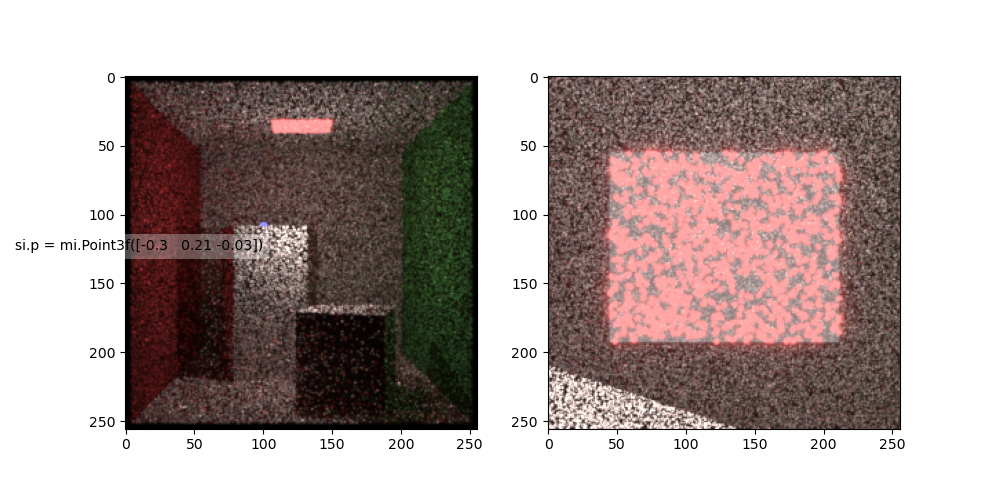

In [18]:
ray2 = mi.Ray3f([-0.3, 0.8, -0.03], [0, -1, 0])
si2 = scene.ray_intersect(ray2)
ds_list2 = []
for i in range(N):
    ds_temp, _ = scene.sample_emitter_direction(si2, sampler.next_2d())
    ds_list2.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si2, ds_list2)

In [19]:
mi.cornell_box()['light']

{'type': 'rectangle',
 'to_world': [[0.23, 0, 0, 0],
  [0, -8.30516e-09, -0.19, 0.99],
  [0, 0.19, -8.30516e-09, 0.01],
  [0, 0, 0, 1]],
 'bsdf': {'type': 'ref', 'id': 'white'},
 'emitter': {'type': 'area',
  'radiance': {'type': 'rgb', 'value': [18.387, 13.9873, 6.75357]}}}

In [20]:
ds, weight = scene.sample_emitter_direction(si, u, test_visibility=False)
print(ds, "\n")
print(weight, "\n")

DirectionSample3f[
  p = [-0.123591, 0.99, 0.159702],
  n = [0, -1, -4.37114e-08],
  uv = [0.231325, 0.893952],
  time = 0,
  pdf = 24.413,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBEmitterSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [-0.930451, 0.341717, 0.13225],
  dist = 1.20758
] 

[0.7531650066375732, 0.5729452967643738, 0.27663853764533997] 



In [21]:
ds0, weight0 = scene.emitters()[0].sample_direction(si, u)
print(f"{si.p = }")
print(ds0)
print(weight0)
print(scene.emitters()[0].pdf_direction(si, ds0))
print(dr.dot(ds0.d, ds0.n))

si.p = [1.0, 0.5773502588272095, 2.605401771470185e-15]
DirectionSample3f[
  p = [-0.123591, 0.99, 0.159702],
  n = [0, -1, -4.37114e-08],
  uv = [0.231325, 0.893952],
  time = 0,
  pdf = 24.413,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBEmitterSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [-0.930451, 0.341717, 0.13225],
  dist = 1.20758
]
[0.7531650066375732, 0.5729452967643738, 0.27663853764533997]
24.412979125976562
-0.341717338382371


In [22]:
emit = ds0.emitter
print(emit.eval(si))
print(emit.eval_direction(si, ds))

[18.386999130249023, 13.987299919128418, 6.753570079803467]
[18.386999130249023, 13.987299919128418, 6.753570079803467]


In [23]:
rect = scene.shapes()[5]
print(f"{rect.is_emitter() = }\n")

ds_rect = rect.sample_direction(si, u)
print(ds_rect)
print(rect.pdf_direction(si, ds_rect))
print(dr.allclose(ds_rect.pdf, rect.pdf_direction(si, ds_rect)))

rect.is_emitter() = True

DirectionSample3f[
  p = [-0.123591, 0.99, 0.159702],
  n = [0, -1, -4.37114e-08],
  uv = [0.231325, 0.893952],
  time = 0,
  pdf = 24.413,
  delta = 0,
  emitter = nullptr,
  d = [-0.930451, 0.341717, 0.13225],
  dist = 1.20758
]
24.412979125976562
True


In [24]:
ds, weight = scene.sample_emitter_direction(mi.SurfaceInteraction3f(), u)
print(f"{type(ds) = }")
print(ds, "\n")
print(f"{type(weight) = }")
print(weight)

type(ds) = <class 'mitsuba.scalar_rgb.DirectionSample3f'>
DirectionSample3f[
  p = [-0.123591, 0.99, 0.159702],
  n = [0, -1, -4.37114e-08],
  uv = [0.231325, 0.893952],
  time = 0,
  pdf = 5.96053,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBEmitterSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [-0.12232, 0.979824, 0.15806],
  dist = 1.01039
] 

type(weight) = <class 'mitsuba.scalar_rgb.Color3f'>
[3.084791660308838, 2.3466529846191406, 1.1330482959747314]
